# Final Project

In [31]:
# Import statements
import os
import re
import nltk
import pandas as pd
import numpy as np
from afinn import Afinn
import matplotlib.pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Tabs
from bokeh.layouts import gridplot, column, row, WidgetBox
from bokeh.plotting import figure, show, output_file
from collections import Counter
import networkx as nx
from netwulf import visualize

In [32]:
# Function to create the dataframe of tweets and list of accounts
def create_df(c):
    df = pd.DataFrame()
    names = []
    for f in os.listdir("tweets/%s" % c):
        if (f.endswith(".csv")):
            try:
                dft = pd.read_csv("tweets/%s/%s" % (c, f))[['username', 'text']]
                df = pd.concat([df, dft])

                # parse output_name.csv string
                names.append(f[7:][:-4])
            except:
                print(f)
    df = df[['username', 'text']].copy().dropna()
    return df, names

In [33]:
# Create dataframes for each category

categories = ["fast food", "airlines", "leagues", "colleges", "tech giants", "streaming platforms", "news", "celebrities"]

fast_food, ff_names = create_df(categories[0])
airlines, al_names = create_df(categories[1])
leagues, lg_names = create_df(categories[2])
colleges, cl_names = create_df(categories[3])
tech, tg_names = create_df(categories[4])
streaming, st_names = create_df(categories[5])
news, nw_names = create_df(categories[6])
celebs, cb_names = create_df(categories[7])


In [34]:
stopwords = nltk.corpus.stopwords.words("english")

# Clean tweets for sentiment analysis
def get_clean_words(words):
    def _isnum(w):
        try:
            int(w)
            return True
        except ValueError:
            return False
        
    # Set words to lowercase and remove them if they are stop words
    words = [w.lower() for w in words if w.lower() not in stopwords]

    # Remove punctuation
    words = [w.replace('(', '') for w in words]
    words = [w.replace(')', '') for w in words]
    words = [w.replace('?', '') for w in words]
    words = [w.replace(',', '') for w in words]
    words = [w.replace('.', '') for w in words]
    words = [w.replace('"', '') for w in words]
    words = [w.replace('!', '') for w in words]
    words = [w.replace(':', '') for w in words]
    words = [w.replace('&amp;', '') for w in words]
    words = [w.replace('/', '') for w in words]
    words = [w.replace('[', '') for w in words]
    words = [w.replace(']', '') for w in words]
    
    # Remove numbers
    words = [w for w in words if not _isnum(w)]
    
    # Remove links
    words = [w for w in words if 'http' not in w]
        
    # Remove hashtags
    words = [w for w in words if not w.startswith("#")]
    
    # Remove mentions
    words = [w for w in words if not w.startswith("@")]
    
    # Only keep words with more than one character
    words = [w for w in words if len(w) > 1]    
    w = " ".join(words)
    return w

In [35]:
# Funtion to pass each tweet into the clean words function and create a new list
def clean_tweets(df):
    new_text = []
    for i in range(len(df)):
        new_text.append(get_clean_words(df['text'].values[i].split()))
    df.text = new_text

In [36]:
# Clean tweets for each category
clean_tweets(fast_food)
clean_tweets(airlines)
clean_tweets(leagues)
clean_tweets(colleges)
clean_tweets(streaming)
clean_tweets(news)
clean_tweets(tech)
clean_tweets(celebs)

In [68]:
# Function to find the affinity score of a list of tweets
afinn = Afinn()

def get_affinity_scores(tweets):
    scores = []
    count = 0
    for t in tweets:
        if len(t) > 0:
            scores.append(afinn.score(t) / len(t))
        else:
            count += 1
            scores.append(0)
    return scores

In [69]:
# Get affinity scores by category
ff_affin = get_affinity_scores(fast_food['text'].tolist())
al_affin = get_affinity_scores(airlines['text'].tolist())
lg_affin = get_affinity_scores(leagues['text'].tolist())
cl_affin = get_affinity_scores(colleges['text'].tolist())
st_affin = get_affinity_scores(streaming['text'].tolist())
nw_affin = get_affinity_scores(news['text'].tolist())
tg_affin = get_affinity_scores(tech['text'].tolist())
cb_affin = get_affinity_scores(celebs['text'].tolist())

fast_food['affin'] = ff_affin
airlines['affin'] = al_affin
leagues['affin'] = lg_affin
colleges['affin'] = cl_affin
streaming['affin'] = st_affin
news['affin'] = nw_affin
tech['affin'] = tg_affin
celebs['affin'] = cb_affin

affin = [ff_affin, al_affin, lg_affin, cl_affin, tg_affin, st_affin, nw_affin, cb_affin]

In [57]:
# Calculate the average affinity score for each account in a category
def affin_by_acct(df, names):
    acct = []
    for n in names:
        affin = df[df['username'].str.lower() == n.lower()]['affin'].tolist()
        acct.append(np.mean(affin))
    return acct

In [40]:
# Calculate affinity by account
ff_acct = affin_by_acct(fast_food, ff_names)
al_acct = affin_by_acct(airlines, al_names)
lg_acct = affin_by_acct(leagues, lg_names)
cl_acct = affin_by_acct(colleges, cl_names)
st_acct = affin_by_acct(streaming, st_names)
nw_acct = affin_by_acct(news, nw_names)
tg_acct = affin_by_acct(tech, tg_names)
cb_acct = affin_by_acct(celebs, cb_names)

names = [ff_names, al_names, lg_names, cl_names, tg_names, st_names, nw_names, cb_names]
acct = [ff_acct, al_acct, lg_acct, cl_acct, tg_acct, st_acct, nw_acct, cb_acct]

/Users/camillebowman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


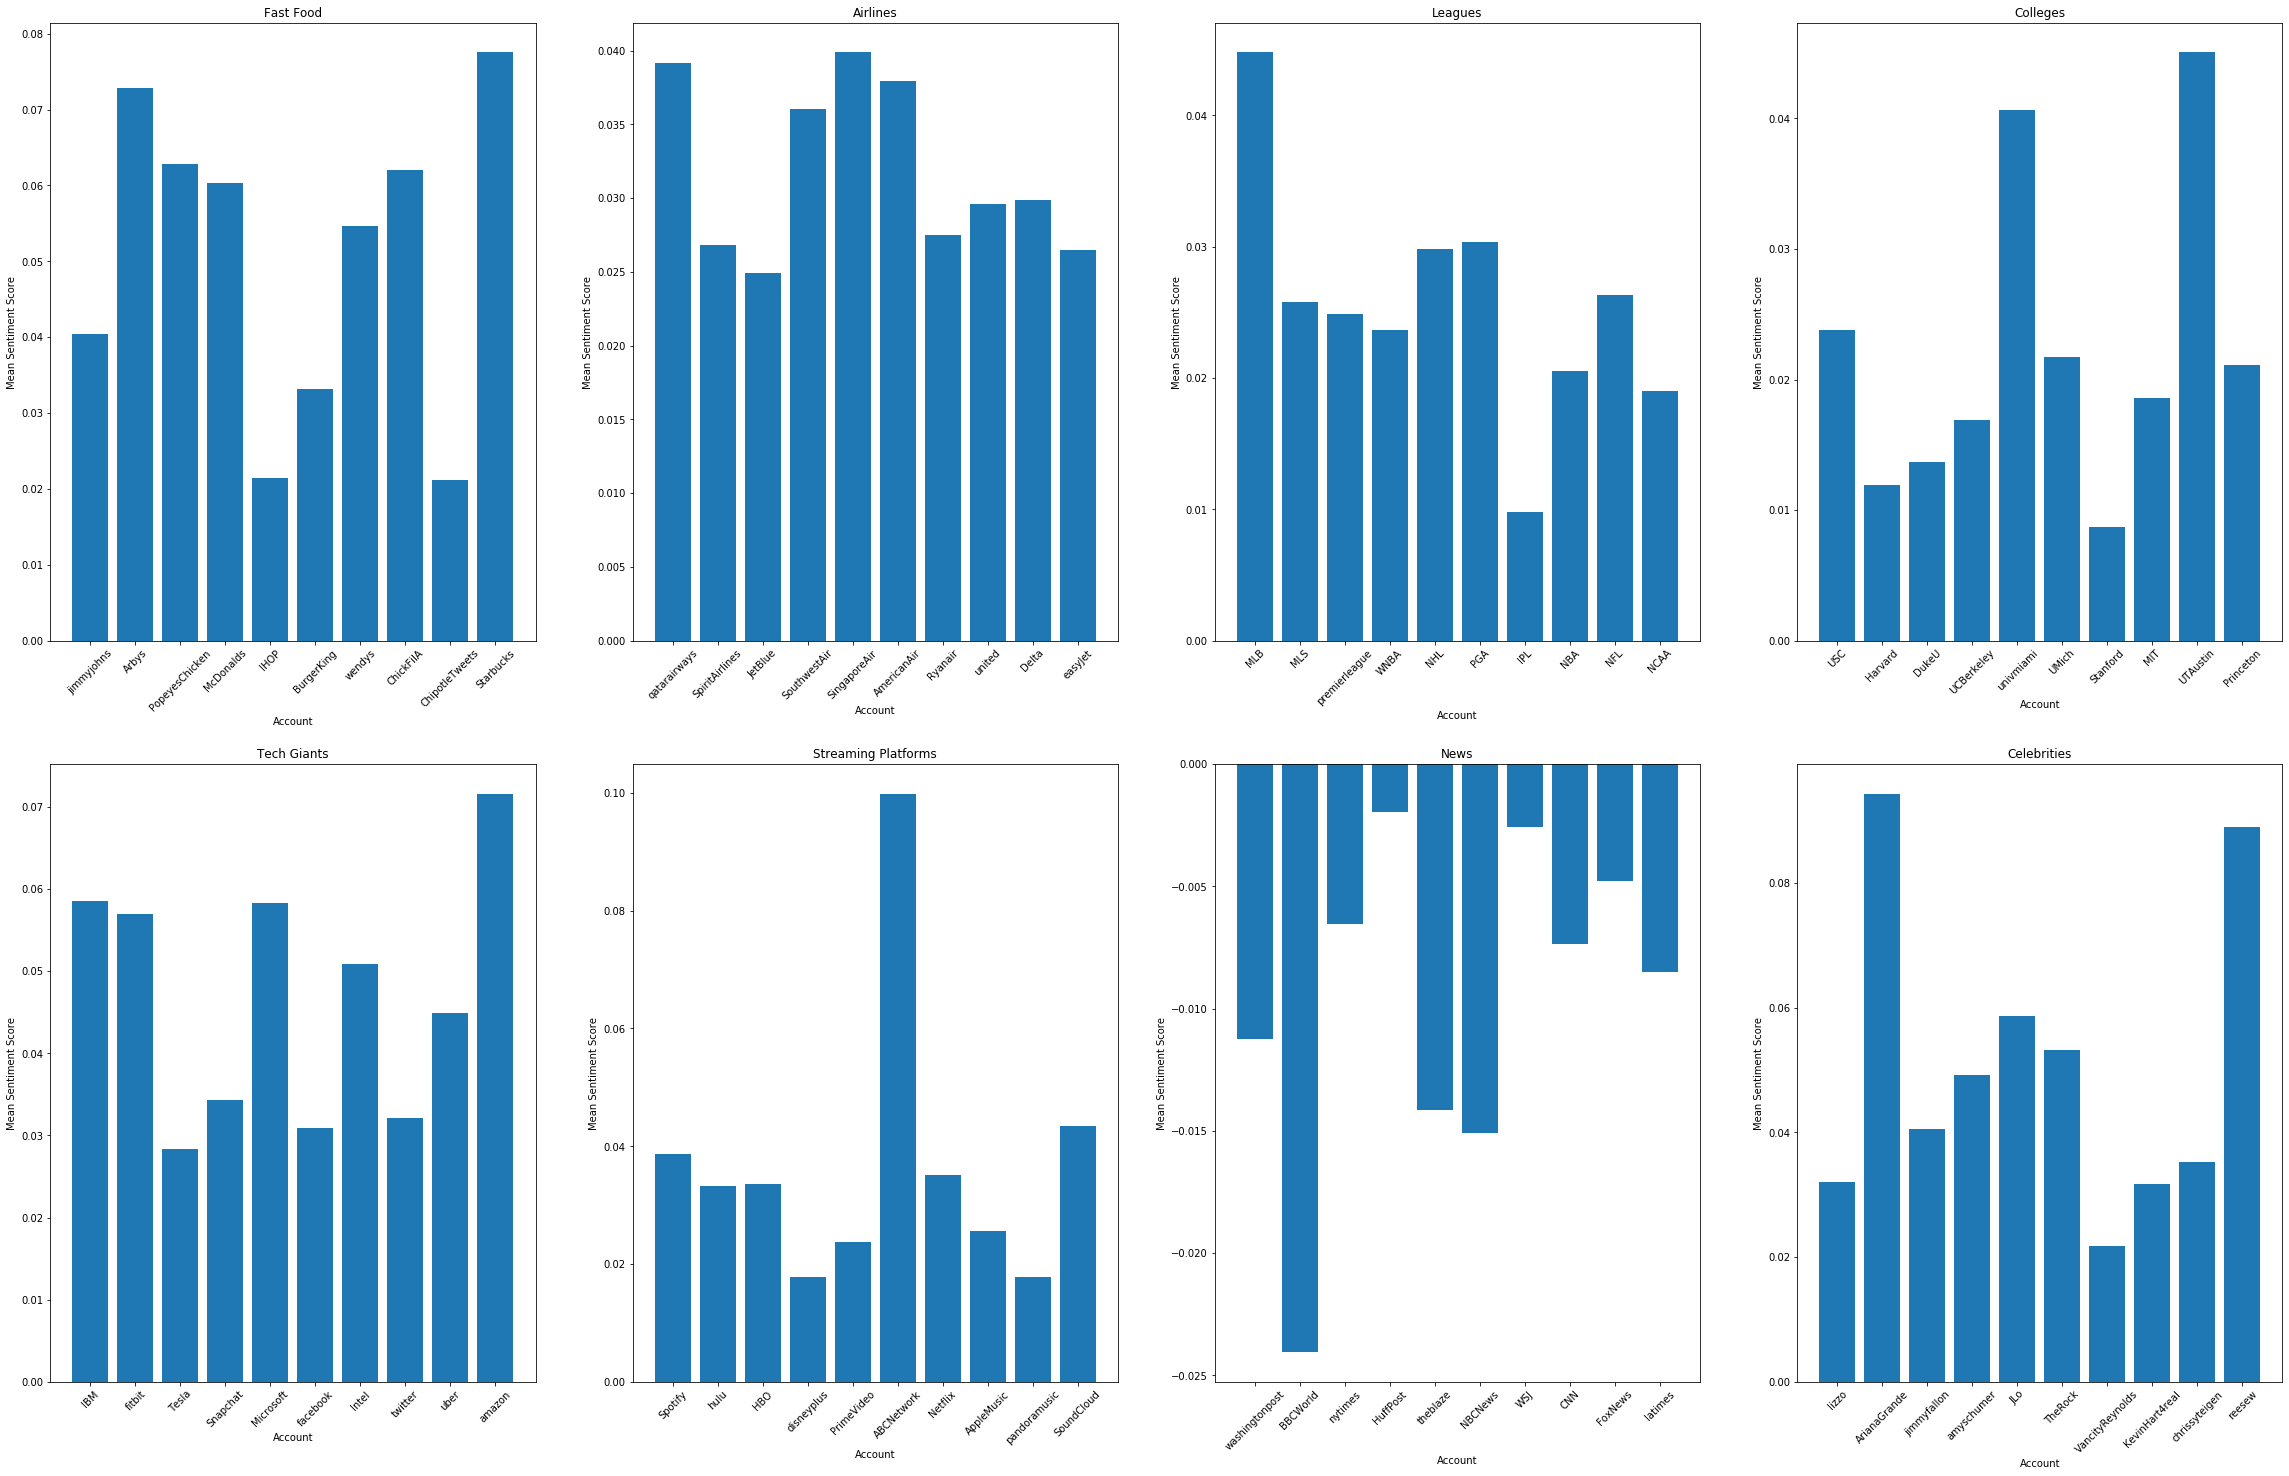

In [41]:
# Plot bar charts of the average affinity score by account for each category
fig, ax = plt.subplots(2, 4, figsize = (40, 25))
props = {"rotation" : 45}

for i in range(len(names)):
    r = int(i / 4)
    c = int(i % 4)
    ax[r, c].bar(names[i], acct[i])
    ax[r, c].set_title(categories[i].title())
    plt.setp(ax[r, c].get_xticklabels(), **props)
    ax[r, c].set_xlabel("Account")
    ax[r, c].set_ylabel("Mean Sentiment Score")

fig.show()

/Users/camillebowman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


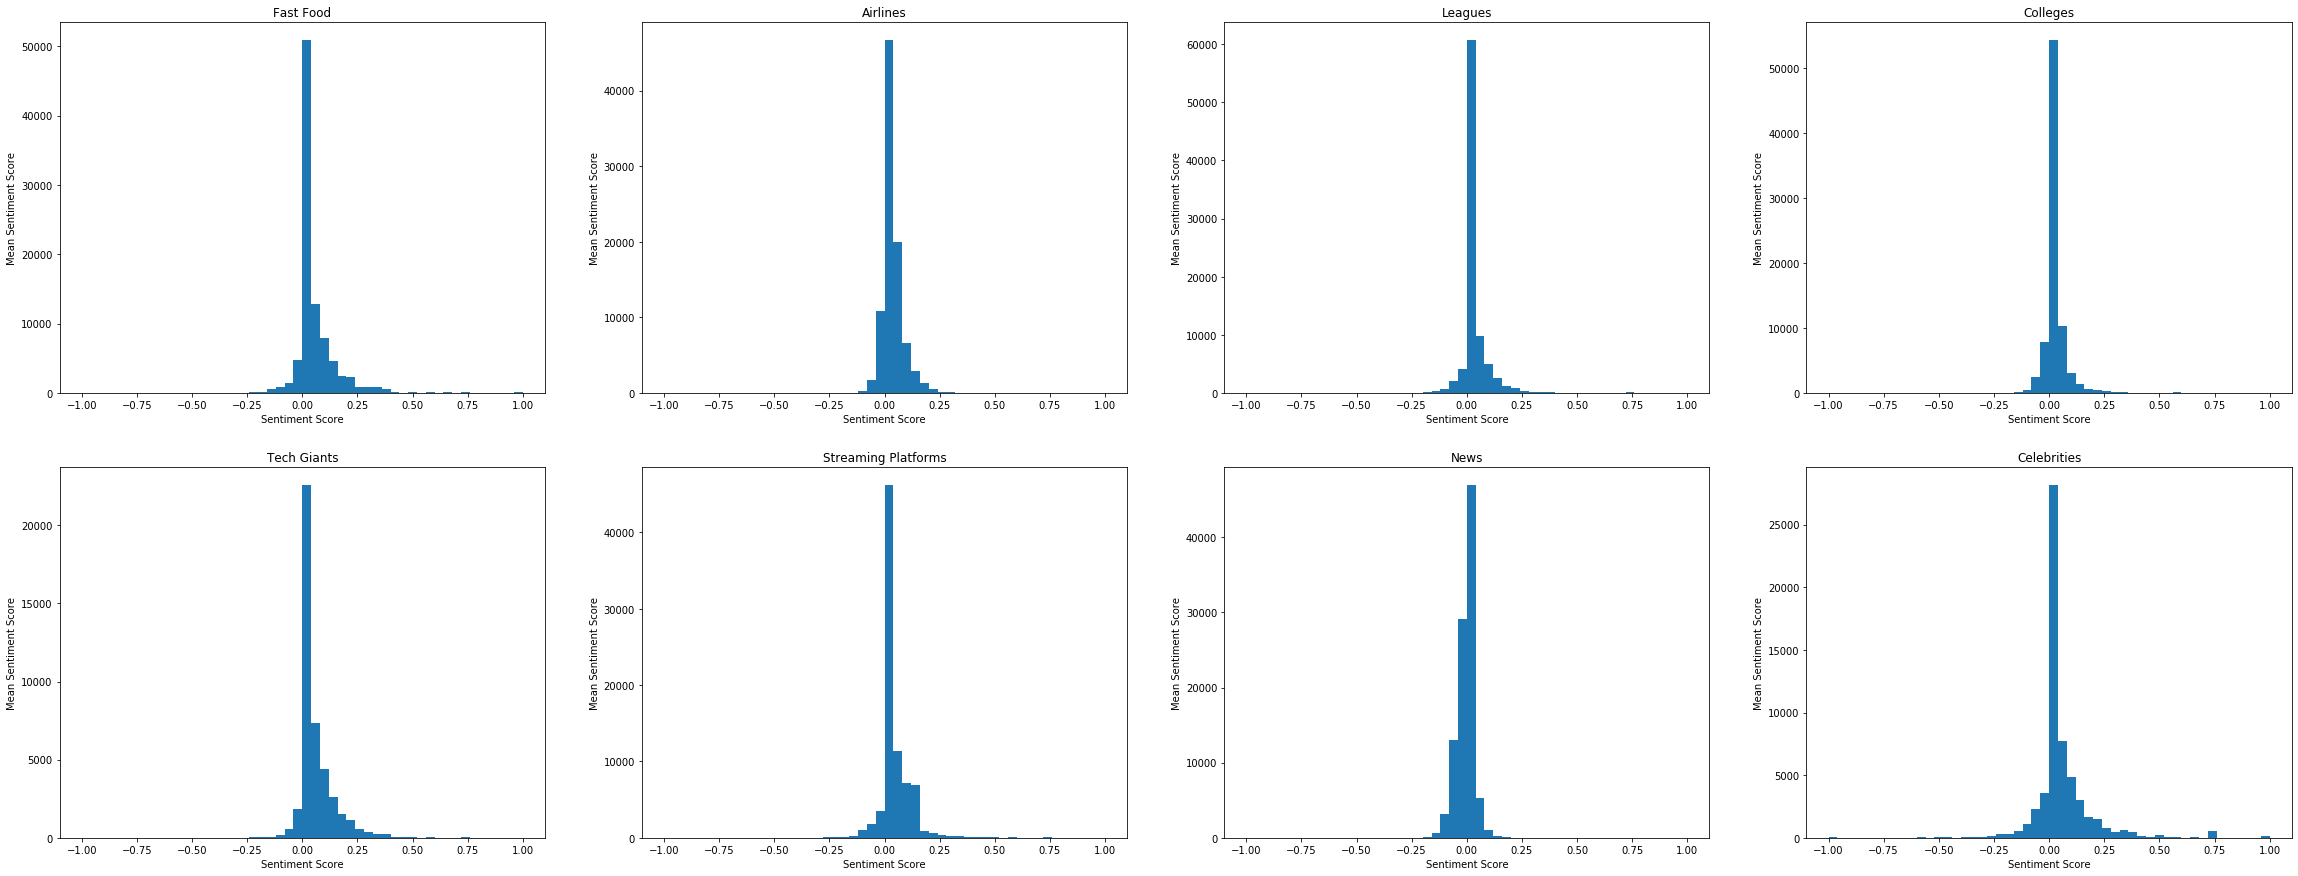

In [42]:
# Plot bar charts of the average affinity score by account for each category
fig, ax = plt.subplots(2, 4, figsize = (40, 15))

for i in range(len(names)):
    r = int(i / 4)
    c = int(i % 4)
    ax[r, c].hist(affin[i], bins=50, range=[-1, 1])
    ax[r, c].set_title(categories[i].title())
    ax[r, c].set_xlabel("Sentiment Score")
    ax[r, c].set_ylabel("Mean Sentiment Score")

fig.show()

In [43]:
# –––––––––––– Histogram parameters –––––––––––
start = -1     # low end of the histogram
end = 1        # high end of the histogram
bin_ct = 50    # number of bins
# –––––––––––––––––––––––––––––––––––––––––––––

# Calculate histograms by category
ff_hist, ff_edges = np.histogram(ff_affin, bins = bin_ct, range = [start, end])
al_hist, al_edges = np.histogram(al_affin, bins = bin_ct, range = [start, end])
lg_hist, lg_edges = np.histogram(lg_affin, bins = bin_ct, range = [start, end])
cl_hist, cl_edges = np.histogram(cl_affin, bins = bin_ct, range = [start, end])
st_hist, st_edges = np.histogram(st_affin, bins = bin_ct, range = [start, end])
nw_hist, nw_edges = np.histogram(nw_affin, bins = bin_ct, range = [start, end])
tg_hist, tg_edges = np.histogram(tg_affin, bins = bin_ct, range = [start, end])
cb_hist, cb_edges = np.histogram(cb_affin, bins = bin_ct, range = [start, end])

# Create lists of histogram values, edges, colors, and categories for plotting
hist = [ff_hist, al_hist, lg_hist, cl_hist, tg_hist, st_hist, nw_hist, cb_hist]
# Normalize the histogram
hist = [[hh / np.sum(h) for hh in h] for h in hist]
edges = [ff_edges, al_edges, lg_edges, cl_edges, tg_edges, st_edges, nw_edges, cb_edges]
colors = ['red', 'orange', 'lightgreen', 'darkgreen', 'lightblue', 'navy', 'violet', 'darkviolet']
categories = ["Fast Food", "Airlines", "Sports Leagues", "Colleges", "Tech Giants", "Streaming Sites", "News Outlets", "Celebrities"]


In [44]:
# Create interactive bokeh histogram for all categories (try clicking the legend!)

# Construct the plot
p = figure(plot_width = 700, plot_height = 700, 
                  title = 'Histogram of Sentiment Analysis by Category',
                  x_axis_label = 'Sentiment Score', y_axis_label = 'Proportion')


for i in range(len(hist)):
    # Create a histogram for each category
    p.quad(bottom = 0, top = hist[i], left = edges[i][:-1], right = edges[i][1:],
               color = colors[i], fill_alpha = 0.7, legend = categories[i],
               line_color = 'white')

# Set legend to hide a given category when clicked
p.legend.click_policy="hide"

show(p)


In [62]:
# Function to flatten all tweets for a given account into one list, and return a list of these flattened lists
def split_words(df, names):
    acct_words = []
    for n in names:
        t = df[df['username'].str.lower() == n.lower()]['text'].tolist()
        t_t = [ti.split() for ti in t]
        t_n = [t_ij for t_i in t_t for t_ij in t_i]
        acct_words.append(t_n)
    return acct_words


In [63]:
# Create account-level lists for each category
ff_by_acct = split_words(fast_food, ff_names)
al_by_acct = split_words(airlines, al_names)
lg_by_acct = split_words(leagues, lg_names)
cl_by_acct = split_words(colleges, cl_names)
tg_by_acct = split_words(tech, tg_names)
st_by_acct = split_words(streaming, st_names)
nw_by_acct = split_words(news, nw_names)
cb_by_acct = split_words(celebs, cb_names)


In [47]:
# Find top 10 words for each account in a category
def top_10_by_acct(words):
    top10 = []
    for i in range(len(words)):
        t = []
        c = Counter(words[i]).most_common(10)
        for j in range(10):
            t.append(c[j][0])
        top10.append(t)
    return top10

In [72]:
# Find top 10 words for all accounts in each category
ff_10 = top_10_by_acct(ff_by_acct)
al_10 = top_10_by_acct(al_by_acct)
lg_10 = top_10_by_acct(lg_by_acct)
cl_10 = top_10_by_acct(cl_by_acct)
tg_10 = top_10_by_acct(tg_by_acct)
st_10 = top_10_by_acct(st_by_acct)
nw_10 = top_10_by_acct(nw_by_acct)
cb_10 = top_10_by_acct(cb_by_acct)
top_10 = [ff_10, al_10, lg_10, cl_10, tg_10, st_10, nw_10, cb_10]


In [75]:
# Top 10 Words by Account
# ––––––––––––––––– FORMATTING PARAMETERS ––––––––––––––––––––––––––––––––––––––––––––––––––––––––
btwn = 2                                             # Amount of space between each column
col = 20                                             # Column width
ncol = 5                                             # Number of columns
before = 4                                           # Amount of space allocated for numbers
total_size = before + col * ncol + btwn * (ncol - 1) # Total length of each row
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

for i in range(len(categories)):
    
    # Print category heading
    print("=" * total_size)
    print(categories[i].upper().center(col * ncol + btwn * (ncol - 1)))
    print("=" * total_size)
    print("-" * total_size)
    
    # Create account headings
    acct_1 = (" " * before)
    acct_2 = (" " * before)
    n = names[i]
    for j in range(ncol):
        acct_1 += n[j].title().center(col)
        acct_1 += (" " * btwn)
        acct_2 += n[j + ncol].title().center(col)
        acct_2 += (" " * btwn)
    
    # Print first 5 account headings and their top 10 words
    print(acct_1)
    print("-" * total_size)
    for j in range(10):
        s = (str(j + 1) + ".").ljust(before)
        for k in range(ncol):
            s += top_10[i][k][j].center(col)
            s += (" " * btwn)
        print(s)
    print()
    
    # Print next 5 account headings and their top 10 words
    print("-" * total_size)
    print(acct_2)
    print("-" * total_size)
    for j in range(10):
        s = (str(j + 1) + ".").ljust(before)
        for k in range(ncol):
            s += top_10[i][k + ncol][j].center(col)
            s += (" " * btwn)
        print(s)    
        
    # Print dividers
    print()
    print()

                                                 FAST FOOD                                                  
----------------------------------------------------------------------------------------------------------------
         Jimmyjohns              Arbys             Popeyeschicken          Mcdonalds                Ihop          
----------------------------------------------------------------------------------------------------------------
1.          i'm                    us                    us                  sorry                   us           
2.         sorry                  you                  please                please                please         
3.           ya                  arby's                thanks                  us               866-444-5144      
4.         store                 we're                   dm                  friend                 m-f           
5.           dm                   see                   you                  thanks       

# Find top 10 words in a category
def top_10(words):
    t = []
    c = Counter(words).most_common(10)
    for j in range(10):
        t.append(c[j][0])
    return t

In [59]:
# Flatten account-level tweet lists
ff_all = [f for ff in ff_by_acct for f in ff]
al_all = [f for ff in al_by_acct for f in ff]
lg_all = [f for ff in lg_by_acct for f in ff]
cl_all = [f for ff in cl_by_acct for f in ff]
tg_all = [f for ff in tg_by_acct for f in ff]
st_all = [f for ff in st_by_acct for f in ff]
nw_all = [f for ff in nw_by_acct for f in ff]
cb_all = [f for ff in cb_by_acct for f in ff]

# Calculate top 10 words for each category
ff_all_10 = top_10(ff_all)
al_all_10 = top_10(al_all)
lg_all_10 = top_10(lg_all)
cl_all_10 = top_10(cl_all)
tg_all_10 = top_10(tg_all)
st_all_10 = top_10(st_all)
nw_all_10 = top_10(nw_all)
cb_all_10 = top_10(cb_all)

all_10 = [ff_all_10, al_all_10, lg_all_10, cl_all_10, tg_all_10, st_all_10, nw_all_10, cb_all_10]


In [60]:
# Create a graph of categories and top 10 words
G = nx.Graph()
G.add_nodes_from(categories)
for i in range(len(categories)):
    for j in range(10):
        G.add_edge(categories[i], all_10[i][j])

/Users/camillebowman/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


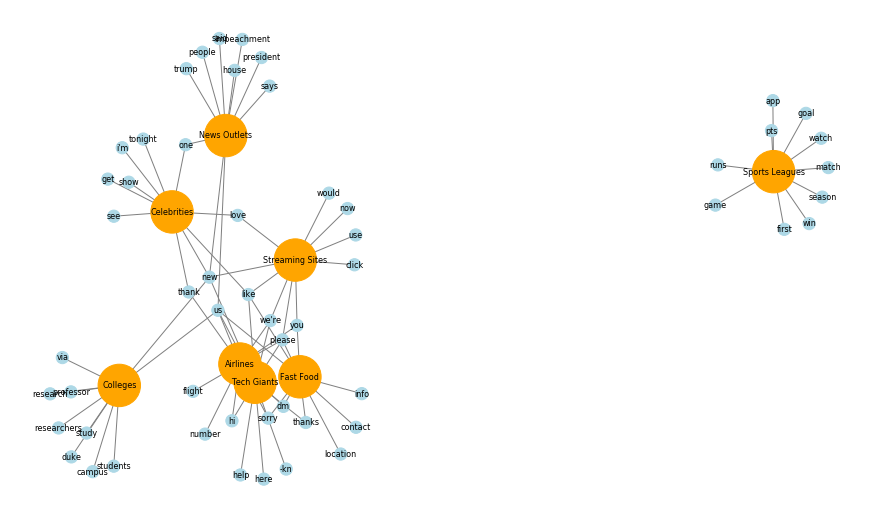

In [61]:
# –––––––––––– Graph parameters ––––––––––––––––––
color_map = []     # Map of colors for each node
size_map = []      # Map of sizes for each node
# ––––––––––––––––––––––––––––––––––––––––––––––––

# Set all category nodes to orange and size 1800
for i in range(len(categories)):
    color_map.append("orange")
    size_map.append(1800)

# Set all word nodes to light blue and size 150
for i in range(len(G.nodes()) - len(categories)):
    color_map.append("lightblue")
    size_map.append(150)

# Plot the graph
plt.figure(3,figsize=(12,7))
nx.draw(G, node_color = color_map, node_size=size_map, with_labels=True, font_size=8, edge_color='grey')
plt.show()


In [ ]:
# Use Netwulf to visualize the graph (more dynamic but cannot set sizes/colors for nodes)
visualize(G)